In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer

from pymystem3 import Mystem
from string import punctuation
import nltk
nltk.download("stopwords")
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk import word_tokenize 
from nltk.util import ngrams

!pip install swifter
import swifter
from tqdm import tqdm

import numpy as np
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 647 kB 4.9 MB/s 
     |████████████████████████████████| 280 kB 47.2 MB/s 
     |████████████████████████████████| 136 kB 50.8 MB/s 
  Created wheel for swifter: filename=swifter-1.1.3-py3-none-any.whl size=13078 sha256=be5b8cd7308f035a321f326c09386a242f991f6e13658456975713165fbbe31a
  Stored in directory: /root/.cache/pip/wheels/e8/1a/1b/46aa7b0fac16d3ce1bccaac14bfe4fad972642217ae78d8160
Successfully built swifter
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [ ]:
df = pd.read_csv('output (1).csv', sep=';', index_col=0, parse_dates=['workStartDate'], decimal=',')
df.head()

,Unnamed: 0.1,Unnamed: 0.1.1,clientId,workUnit,workUnitPrice,workStartDate,latitude,longitude,name,description,...,ub052021,ub062021,ub072021,ub082021,ub092021,ub102021,ub112021,ub122021,ub012022,ub022022
0,0,0,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-01-04,55.816065,37.458660,инженер-строительством,Контроль объемов и качества выполненных работ ...,...,2.8,2.7,2.6,2.5,2.4,2.3,2.3,2.3,2.2,2.2
1,1,1,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-01-04,55.765458,37.796517,Электрик,Организация выполнения электротехнических рабо...,...,2.8,2.7,2.6,2.5,2.4,2.3,2.3,2.3,2.2,2.2
2,2,2,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-01-04,55.685041,37.350683,Укладка пеноблоки с послойной (999) 890-55-38,Укладка пеноблоков\nМеханизированным способом\...,...,2.8,2.7,2.6,2.5,2.4,2.3,2.3,2.3,2.2,2.2
3,3,3,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-01-04,55.816065,37.458660,Руководил бригадой строителей,Управление бригадой 30 человек (923) 108-89-96,...,2.8,2.7,2.6,2.5,2.4,2.3,2.3,2.3,2.2,2.2
4,4,4,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-01-04,55.685041,37.350683,Геодезист,"Выполнение комплекса геодезических работ, обес...",...,2.8,2.7,2.6,2.5,2.4,2.3,2.3,2.3,2.2,2.2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8313 entries, 0 to 8312
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Unnamed: 0.1            8313 non-null   int64         
 1   Unnamed: 0.1.1          8313 non-null   int64         
 2   clientId                8313 non-null   object        
 3   workUnit                8313 non-null   object        
 4   workUnitPrice           8313 non-null   float64       
 5   workStartDate           8313 non-null   datetime64[ns]
 6   latitude                8313 non-null   float64       
 7   longitude               8313 non-null   float64       
 8   name                    8313 non-null   object        
 9   description             8313 non-null   object        
 10  address                 8313 non-null   object        
 11  specialityId            8313 non-null   object        
 12  year                    8313 non-null   int64   

In [ ]:
df['year'] = df['workStartDate'].dt.year
df['month'] = df['workStartDate'].dt.month

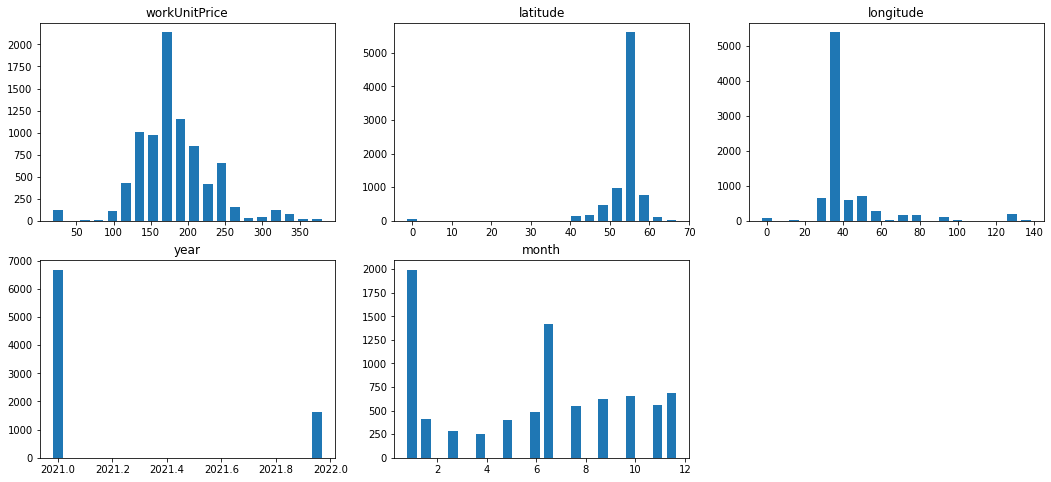

In [ ]:
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize = (columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins = 20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()

visualize_distributions({
    'workUnitPrice': df['workUnitPrice'].dropna(),
    'latitude': df['latitude'].dropna(),
    'longitude': df['longitude'].dropna(),
    'year': df['year'].dropna(),
    'month': df['month'].dropna()
})

In [ ]:
#df['workUnitPrice'].min()
#df['workUnitPrice'].max()

25.0

In [ ]:
!pip install pymorphy2
import pymorphy2
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
import time

russian_stopwords = stopwords.words("russian")
lemma = pymorphy2.MorphAnalyzer()

#Код функции обработки текста:
def preprocess_text(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in russian_stopwords])
    punc_free = ''.join(ch for ch in stop_free if ch not in punctuation)
    text = " ".join([lemma.parse(word)[0].normal_form for word in punc_free.split(' ')])
    return text

df['lemmatized_description'] = df['description'].swifter.apply(preprocess_text)
df.head()

     |████████████████████████████████| 55 kB 1.8 MB/s 
     |████████████████████████████████| 8.2 MB 10.2 MB/s 


Pandas Apply:   0%|          | 0/8313 [00:00<?, ?it/s]

,Unnamed: 0.1,Unnamed: 0.1.1,clientId,workUnit,workUnitPrice,workStartDate,latitude,longitude,name,description,...,ub052021,ub062021,ub072021,ub082021,ub092021,ub102021,ub112021,ub122021,ub012022,ub022022
0,0,0,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-01-04,55.816065,37.458660,инженер-строительством,Контроль объемов и качества выполненных работ ...,...,2.8,2.7,2.6,2.5,2.4,2.3,2.3,2.3,2.2,2.2
1,1,1,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-01-04,55.765458,37.796517,Электрик,Организация выполнения электротехнических рабо...,...,2.8,2.7,2.6,2.5,2.4,2.3,2.3,2.3,2.2,2.2
2,2,2,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-01-04,55.685041,37.350683,Укладка пеноблоки с послойной (999) 890-55-38,Укладка пеноблоков\nМеханизированным способом\...,...,2.8,2.7,2.6,2.5,2.4,2.3,2.3,2.3,2.2,2.2
3,3,3,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-01-04,55.816065,37.458660,Руководил бригадой строителей,Управление бригадой 30 человек (923) 108-89-96,...,2.8,2.7,2.6,2.5,2.4,2.3,2.3,2.3,2.2,2.2
4,4,4,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-01-04,55.685041,37.350683,Геодезист,"Выполнение комплекса геодезических работ, обес...",...,2.8,2.7,2.6,2.5,2.4,2.3,2.3,2.3,2.2,2.2


In [ ]:
#df.to_csv('without_last_two_weeks.csv')

In [ ]:
russian_stopwords = stopwords.words("russian")

vectorizer = TfidfVectorizer(stop_words=russian_stopwords, token_pattern=u'(?ui)\\b\\w*[а-я]+\\w*\\b', ngram_range=(2,2))
matrix_tfidf = vectorizer.fit_transform(df['lemmatized_description'])

In [ ]:
top_words = pd.DataFrame(columns=df['specialityId'].unique())

def get_top_for_group(descriptions: pd.Series, group: str):
    global top_words
    if len(descriptions)<2 and len(descriptions.iloc[0].split())<2:
        return
    matrix_tfidf = vectorizer.fit_transform(descriptions)
    feature_array = np.array(vectorizer.get_feature_names())
    tfidf_sorting = np.argsort(matrix_tfidf.toarray()).flatten()[::-1]

    n = 10
    top_n = feature_array[tfidf_sorting][:n]
    top_words[group] = pd.Series(top_n)

In [ ]:
for group in top_words.keys():
    descriptions = df[df['specialityId']==group]['lemmatized_description']
    get_top_for_group(descriptions, group)

top_words

,af02837b-7814-43d0-97ab-48b2b9813120,6c183c81-cdb8-4d9c-a48f-877a516a93bc,256464cf-39f5-405c-a006-6b1505f6a961,7ce33ae6-7b86-48e8-9698-7650b3cbe42e,889bf632-b7e6-4c9e-887d-fa06acc47f10,4f1a1b97-21c8-4f64-badf-ab4760eebaed,623c4e3e-5971-43f7-895a-c9e68abf9ede,122997d2-780f-4103-ac0a-4178dd479934,d55e4589-beac-4964-bd69-d7efff11290c,708435b6-3756-4edd-91a8-6275c55a5199,...,02aa72e5-25f4-4431-b9ae-c0e884b9eec3,b702d1bc-3bb8-4ef3-9cec-c5497bdd3c1b,7d225fcd-e2f4-4d4f-9b32-ccfe41d00338,2781a00b-692a-4e31-aee4-e38f40ba1204,0c0e3d17-3d22-458b-aad0-e6a578c091f8,fed91815-58de-49a1-ae0b-2f5deb32a6f3,643112d9-7adc-4017-87b4-f2c99c4c4ee4,2968c6b3-07f2-4f0c-b314-eabaf536d94d,2ce10ad8-3312-4c09-98ff-446824a9db8b,fbdb0f85-1254-4820-b656-09ec907d91ff
0,требование нормативный,электротехнический работа,цементный молоко,торговый зал,точный соответствие,товар торговый,товар мерчандайзинг,электронный площадка,товар предпродажный,товар мерчандайзинг,...,сборка букет,обработка заказ,центр дневный,час наш,система видеонаблюдение,яндекс тд,торговый зал,электроинструмент строительный,февраль время,NaN
1,соответствие выполнять,организация проведение,пеноблок механизировать,работник торговый,соответствие проект,торговый зал,подготовка товар,функционал электронный,предпродажный подготовка,подготовка товар,...,заказ день,заказ день,торговый центр,звонок час,работа система,нуля обеспечение,выкладка торговый,строительный работа,требование размер,NaN
2,работа требование,выполнение электротехнический,доставляться техника,управление бригада,работа обеспечивать,выкладка товар,товар предпродажный,услуга направить,товар мерчандайзинг,предпродажный подготовка,...,букет заказ,выкладка товар,проверка qrкод,наш сотрудник,накладный контроль,маркетплейс формирование,торговый зал,работа работа,размер нога,NaN
3,работа подрядный,выполнить работа,захватка ручной,товар прилавок,проект геометрический,этикетка скомпановать,предпродажный подготовка,поручение заказчик,подготовка товар,товар предпродажный,...,сборка букет,обработка заказ,дневный график,сотрудник обрабатывать,контроль накладный,маркетплейс яндекс,выкладка торговый,работа электроинструмент,примерка отбор,NaN
4,проектный документация,исполнительный документация,каждый смотреть,выкладка товар,обеспечивать точный,мир фототчёт,выкладка товар,оказать комплекс,выкладка товар,выкладка товар,...,заказ день,заказ день,qrкод торговый,обрабатывать звонок,контроль выходавход,маркировка контроль,NaN,слесарный работа,приглашать девушка,NaN
5,подрядный организация,контроль выполнение,куб оплата,бригада человек,комплекс геодезический,навешивание вещь,эп порядок,обязываться поручение,кассир постоянка,поддержание порядок,...,букет заказ,выкладка товар,центр дневный,рубль звонок,выходавход работа,наименование описание,NaN,технический осмотр,отбор февраль,NaN
6,организация контроль,объект контроль,м3 объём,торговый зал,геометрический параметр,наведение порядок,покупатель выставление,направить консультирование,кондитерский продукция,зал выкладка,...,сборка букет,обработка заказ,торговый центр,ь курировать,торговый зал,наполнение карточка,NaN,прибор запорный,отбор обувной,NaN
7,объём качество,организация выполнение,месяц старт,работник торговый,геодезический работа,мытьё полка,подсорт товар,консультирование клиент,набчелны ул,магазин модис,...,заказ день,заказ день,проверка qrкод,поддержка ь,охрана торговый,необходимый склад,NaN,арматура тд,обязательный требование,NaN
8,нормативный проектный,оформление технический,механизировать способ,управление бригада,выполнение комплекс,мытьё оборудование,поддержание порядок,комплекс услуга,молочный товар,мерчендайзинг поддержание,...,букет заказ,выкладка товар,дневный график,звонок загрузка,система видеонаблюдение,новый площадка,NaN,вентиляция пожаротушение,обувной коллекция,NaN
9,контроль соответствие,учёт выполнить,мм стоимость,товар прилавок,точный соответствие,мужчина постоянка,подготовкаработа тсд,клиент заказчик,молочный отдел,модис предпродажный,...,сборка букет,выкладка товар,qrкод торговы

In [ ]:
def count_words_from_top(description, top_words):
    tokens = nltk.word_tokenize(description)
    bigram = list(ngrams(tokens, 2)) 
    count = 0
    for token in bigram:
        if ' '.join(token) in list(top_words):
            count += 1
    return count

for speciality in df['specialityId'].unique():
    df[speciality] = df['lemmatized_description'].apply(count_words_from_top, args=(top_words[speciality],))

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8313 entries, 0 to 8312
Data columns (total 93 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Unnamed: 0.1                          8313 non-null   int64         
 1   Unnamed: 0.1.1                        8313 non-null   int64         
 2   clientId                              8313 non-null   object        
 3   workUnit                              8313 non-null   object        
 4   workUnitPrice                         8313 non-null   float64       
 5   workStartDate                         8313 non-null   datetime64[ns]
 6   latitude                              8313 non-null   float64       
 7   longitude                             8313 non-null   float64       
 8   name                                  8313 non-null   object        
 9   description                           8313 non-null   object        
 10  

In [ ]:
columns1 = ['uru042021', 'uru052021', 'uru062021', 'uru072021', 'uru082021', 'uru092021', 'uru102021', 'uru112021', 'uru122021', 'uru012022', 'uru022022']
columns2 = ['ub042021', 'ub052021', 'ub062021', 'ub072021', 'ub082021', 'ub092021', 'ub102021', 'ub112021', 'ub122021', 'ub012022', 'ub022022']

In [ ]:
df['02aa72e5-25f4-4431-b9ae-c0e884b9eec3'].value_counts()

0    8304
3       5
1       4
Name: 02aa72e5-25f4-4431-b9ae-c0e884b9eec3, dtype: int64

In [ ]:
columns = list(df['specialityId'].unique())+['year', 'month', 'latitude', 'longitude', 'uz042021', 'uz052021', 'uz062021', 'uz072021', 'uz082021', 'uz092021', 'uz102021', 'uz112021', 'uz122021', 'uz012022', 'uz022022']+columns1+columns2
X = df[columns]
y = df['workUnitPrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
#y_pred_s = pd.Series(y_pred)
#df_s = pd.concat([y_test, X_test], axis=1)

#df_s = df_s.merge(y_pred_s.rename('y_pred'), left_index=True, right_index=True)

In [ ]:
#df_s.to_csv('predict.csv')

In [ ]:
!pip3 install catboost
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostRegressor
RANDOM_SEED = 42
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric='R2',
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         plot=True
         )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
skl_wine_imp = model.get_feature_importance(prettified=True)


#plt.bar(skl_wine_imp['Feature Id'], skl_wine_imp['Importances'])

In [ ]:
skl_wine_imp[skl_wine_imp['Feature Id']=='uru042021']

,Feature Id,Importances
37,uru042021,0.576332


In [ ]:
y_pred = model.predict(X_test)
r2_score(y_test, y_pred)

0.8142172973176139

In [ ]:
mean_absolute_percentage_error(y_test, y_pred)

0.0815478021595891

In [ ]:
m = CatBoostRegressor()

In [ ]:
params = {'iterations': [500, 1000, 5000, 100],
          'max_depth': [4, 6, 10],
          #'loss_function': ['RMSE', 'MultiRMSE', 'SurvivalAft', 'MAE', 'Quantile', 'LogLinQuantile', 'Poisson', 'MAPE'],
          #'l2_leaf_reg': np.logspace(-20, -19, 3),
          #'leaf_estimation_iterations': [10],
          #'eval_metric': ['MAPE'],
          #'use_best_model': ['True'],
          #'logging_level':['Silent'],
          'random_seed': [42, 50]
         }
cb = GridSearchCV(m, params,  scoring='r2')
cb.fit(X_train, y_train)

Выходные данные были обрезаны до нескольких последних строк (5000).
0:	learn: 48.2912415	total: 18.6ms	remaining: 1m 32s
1:	learn: 48.0439094	total: 36.6ms	remaining: 1m 31s
2:	learn: 47.8100324	total: 55.1ms	remaining: 1m 31s
3:	learn: 47.5528547	total: 79.7ms	remaining: 1m 39s
4:	learn: 47.3113711	total: 104ms	remaining: 1m 43s
5:	learn: 47.0761967	total: 122ms	remaining: 1m 41s
6:	learn: 46.8556652	total: 139ms	remaining: 1m 39s
7:	learn: 46.6383624	total: 157ms	remaining: 1m 38s
8:	learn: 46.4183529	total: 175ms	remaining: 1m 36s
9:	learn: 46.2274863	total: 192ms	remaining: 1m 35s
10:	learn: 46.0104692	total: 210ms	remaining: 1m 35s
11:	learn: 45.7919428	total: 228ms	remaining: 1m 34s
12:	learn: 45.5768368	total: 246ms	remaining: 1m 34s
13:	learn: 45.3716835	total: 269ms	remaining: 1m 35s
14:	learn: 45.1805426	total: 294ms	remaining: 1m 37s
15:	learn: 45.0013062	total: 320ms	remaining: 1m 39s
16:	learn: 44.8228826	total: 339ms	remaining: 1m 39s
17:	learn: 44.6257702	total: 361ms	re

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x7fb30b2a4190>,
             param_grid={'iterations': [500, 1000, 5000, 100],
                         'max_depth': [4, 6, 10], 'random_seed': [42, 50]},
             scoring='r2')

In [ ]:
best_param = cb.best_params_
best_param

{'iterations': 5000, 'max_depth': 10, 'random_seed': 50}

In [ ]:
y_pred = cb.best_estimator_.predict(X_test)
r2_score(y_test, y_pred)

0.8155499240031419

In [ ]:
mean_absolute_percentage_error(y_test, y_pred)

0.0779895016749196

# Prediction for test file19042022

In [ ]:
data_prod = pd.read_csv('join2.csv', parse_dates=['workStartDate'], sep=';', decimal = ',')
data_prod.columns


Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'clientId', 'orderId', 'orderManagerId', 'objectId', 'priceListId',
       'name',
       ...
       'ub052021', 'ub062021', 'ub072021', 'ub082021', 'ub092021', 'ub102021',
       'ub112021', 'ub122021', 'ub012022', 'ub022022'],
      dtype='object', length=141)

In [ ]:
data_prod['year'] = data_prod['workStartDate'].dt.year
data_prod['month'] = data_prod['workStartDate'].dt.month

In [ ]:
IQR1 = 24.5
IQR2 = 412.5

In [ ]:
#y25 = data_prod['workUnitPrice'].quantile(q=0.25)
#y75 = data_prod['workUnitPrice'].quantile(q=0.75)
#IQR1 = y25 - 1.5*(y75-y25)
#IQR2 = y75 + 1.5*(y75-y25)

In [ ]:
data_prod = data_prod[(data_prod['workUnitPrice']>IQR1) & (data_prod['workUnitPrice']<IQR2)]

In [ ]:
#data_prod['publicationDate'] = pd.to_datetime(data_prod['publicationDate'], dayfirst=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
#data_prod['publicationDate']=pd.to_datetime(data_prod['publicationDate']).dt.strftime('%Y-%m-%d')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


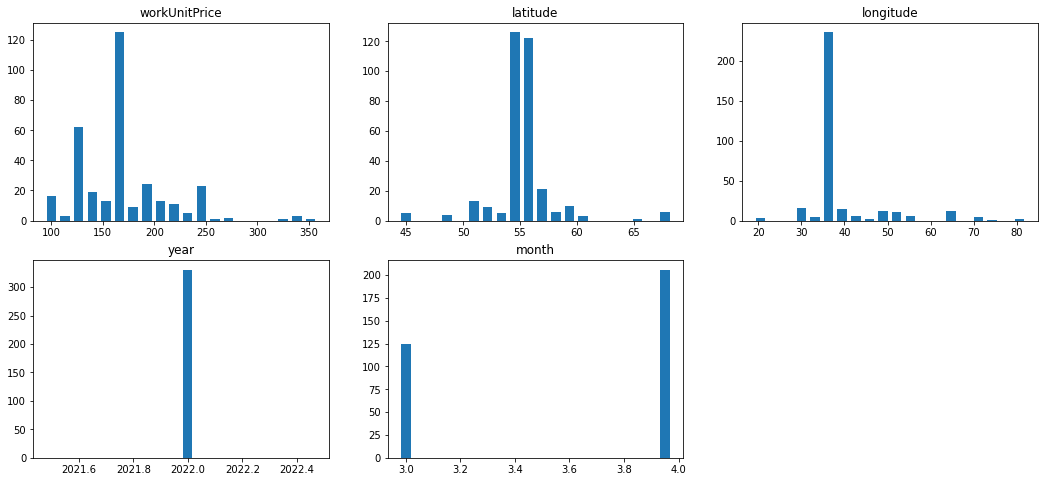

In [ ]:
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize = (columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins = 20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()

visualize_distributions({
    'workUnitPrice': data_prod['workUnitPrice'].dropna(),
    'latitude': data_prod['latitude'].dropna(),
    'longitude': data_prod['longitude'].dropna(),
    'year': data_prod['year'].dropna(),
    'month': data_prod['month'].dropna()
})

In [ ]:
data_prod['lemmatized_description'] = data_prod['description'].swifter.apply(preprocess_text)
data_prod.head()

Pandas Apply:   0%|          | 0/331 [00:00<?, ?it/s]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,clientId,orderId,orderManagerId,objectId,priceListId,name,...,ub082021,ub092021,ub102021,ub112021,ub122021,ub012022,ub022022,year,month,lemmatized_description
0,0,0,0,5821,8aeee516-fe8b-41cc-8a84-1005982fd998,9f2fcf5e-5e71-49a9-9cbd-b55f9bb78718,59cffbdd-fb52-448d-8ce0-d0b33370a03c,6f4621aa-90a3-4088-804c-84aead1d1873,NaN,выкладка товара,...,3.3,3.2,3.1,3.0,3.0,2.9,2.9,2022,4,выкладка товар
1,1,1,1,5845,e09cb55f-b62d-4acc-8647-6a65ec5ea937,794cb0f9-e49e-48c3-81d6-58abeff06df0,9faaf16f-7a4c-4c0c-ae36-a93086e735d9,e851dfce-f649-465f-8650-b7bc9544035a,NaN,Zenden. Мерчандайзинг.,...,4.1,4.2,4.2,4.2,4.2,4.7,4.6,2022,4,проверка соответствие наличие ценник пополнени...
2,2,2,2,5882,ba5f2689-87df-483c-a115-942e1abf130a,9b507ef8-1a60-43dd-aeba-6b5b5e1a4cd6,c475ac8c-c7c5-4368-a4d4-dd11d0b11c88,6b2a2d79-6177-4234-9d50-f7c03b95c24c,NaN,Работник торгового зала,...,2.5,2.4,2.3,2.3,2.3,2.2,2.2,2022,3,выкладка товар прилавок
3,3,3,3,5963,e09cb55f-b62d-4acc-8647-6a65ec5ea937,422db170-ced4-4991-a517-7102c58fa99a,f1056f8a-c08e-4fc6-992d-c5f22b9e5191,0670a2f7-531c-44da-ae97-b194266d1eed,NaN,Zenden. Мерчандайзинг.,...,4.1,4.0,4.0,3.8,3.8,3.8,3.7,2022,4,проверка соответствие наличие ценник пополнени...
4,4,4,4,5964,c9597816-a374-41dc-be3e-b052b25c5582,bf7f0d13-1e44-43fc-9608-d9d6719853cb,9f66e9d8-3065-4af3-90bd-72d9a3809a04,44d948d4-6a65-482f-9ffa-bc0480e519e6,NaN,Zenden. Погрузо-разгрузочные работы.,...,5.5,5.1,4.9,4.8,4.5,4.7,4.7,2022,4,осуществить погрузка разгрузка товар


In [ ]:
for speciality in top_words.keys():
    data_prod[speciality] = data_prod['lemmatized_description'].apply(count_words_from_top, args=(top_words[speciality],))

data_prod.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,clientId,orderId,orderManagerId,objectId,priceListId,name,...,02aa72e5-25f4-4431-b9ae-c0e884b9eec3,b702d1bc-3bb8-4ef3-9cec-c5497bdd3c1b,7d225fcd-e2f4-4d4f-9b32-ccfe41d00338,2781a00b-692a-4e31-aee4-e38f40ba1204,0c0e3d17-3d22-458b-aad0-e6a578c091f8,fed91815-58de-49a1-ae0b-2f5deb32a6f3,643112d9-7adc-4017-87b4-f2c99c4c4ee4,2968c6b3-07f2-4f0c-b314-eabaf536d94d,2ce10ad8-3312-4c09-98ff-446824a9db8b,fbdb0f85-1254-4820-b656-09ec907d91ff
0,0,0,0,5821,8aeee516-fe8b-41cc-8a84-1005982fd998,9f2fcf5e-5e71-49a9-9cbd-b55f9bb78718,59cffbdd-fb52-448d-8ce0-d0b33370a03c,6f4621aa-90a3-4088-804c-84aead1d1873,NaN,выкладка товара,...,0,1,0,0,0,0,0,0,0,0
1,1,1,1,5845,e09cb55f-b62d-4acc-8647-6a65ec5ea937,794cb0f9-e49e-48c3-81d6-58abeff06df0,9faaf16f-7a4c-4c0c-ae36-a93086e735d9,e851dfce-f649-465f-8650-b7bc9544035a,NaN,Zenden. Мерчандайзинг.,...,0,0,0,0,2,0,2,0,0,0
2,2,2,2,5882,ba5f2689-87df-483c-a115-942e1abf130a,9b507ef8-1a60-43dd-aeba-6b5b5e1a4cd6,c475ac8c-c7c5-4368-a4d4-dd11d0b11c88,6b2a2d79-6177-4234-9d50-f7c03b95c24c,NaN,Работник торгового зала,...,0,1,0,0,0,0,0,0,0,0
3,3,3,3,5963,e09cb55f-b62d-4acc-8647-6a65ec5ea937,422db170-ced4-4991-a517-7102c58fa99a,f1056f8a-c08e-4fc6-992d-c5f22b9e5191,0670a2f7-531c-44da-ae97-b194266d1eed,NaN,Zenden. Мерчандайзинг.,...,0,0,0,0,2,0,2,0,0,0
4,4,4,4,5964,c9597816-a374-41dc-be3e-b052b25c5582,bf7f0d13-1e44-43fc-9608-d9d6719853cb,9f66e9d8-3065-4af3-90bd-72d9a3809a04,44d948d4-6a65-482f-9ffa-bc0480e519e6,NaN,Zenden. Погрузо-разгрузочные работы.,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
columns1 = ['uru042021', 'uru052021', 'uru062021', 'uru072021', 'uru082021', 'uru092021', 'uru102021', 'uru112021', 'uru122021', 'uru012022', 'uru022022']
columns3 = ['ub042021', 'ub052021', 'ub062021', 'ub072021', 'ub082021', 'ub092021', 'ub102021', 'ub112021', 'ub122021', 'ub012022', 'ub022022']
columns2 = ['uz042021', 'uz052021', 'uz062021', 'uz072021', 'uz082021', 'uz092021', 'uz102021', 'uz112021', 'uz122021', 'uz012022', 'uz022022']

In [ ]:
columns = list(df['specialityId'].unique())+['year', 'month', 'latitude', 'longitude']+columns1+columns2+columns3
X = data_prod[columns]
y = data_prod['workUnitPrice']

In [ ]:
y_pred = model.predict(X)
r2_score(y, y_pred)

0.7613472614899867

In [ ]:
mean_absolute_percentage_error(y, y_pred)

0.0720757454538349

In [ ]:
y_pred = cb.best_estimator_.predict(X)
r2_score(y, y_pred)

0.74857622873664

In [ ]:
mean_absolute_percentage_error(y, y_pred)

0.06419841446212018